In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import joblib
import re

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [31]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [16]:
# 1) 데이터 로드 & 결합 
df_en = pd.read_csv('CEAS_08.csv')
df_en['text'] = df_en['subject'].fillna('') + ' ' + df_en['body'].fillna('')
df_kr = pd.read_csv('korean_email_500_samples.csv', encoding='utf-8-sig')
df_kr['text'] = df_kr['subject'].fillna('') + ' ' + df_kr['body'].fillna('')
df = pd.concat([df_en[['text','label']], df_kr[['text','label']]], ignore_index=True)

# 2) Train/Test 분할
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
X_train, X_test = train_df['text'], test_df['text']
y_train, y_test = train_df['label'], test_df['label']

# ---------------------추가))한글 데이터 전처리 보완

def clean_text(text):
    # URL, 이메일, 특수문자 등 정규화
    text = re.sub(r'https?://\S+', 'URL', text)
    text = re.sub(r'\S+@\S+', 'EMAIL', text)
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

# ------------------------------------------------

# 3) TF–IDF 벡터화
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

# 4) RandomForestClassifier 훈련
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_tfidf, y_train)

# 5) 평가
y_pred = rf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 6) 모델 저장
joblib.dump({'vectorizer': vectorizer, 'classifier': rf},
            'rf_phishing_model.pkl')
print("Model saved to rf_phishing_model.pkl")


Accuracy: 0.9946
Classification Report:
              precision    recall  f1-score   support

           0     0.9912    0.9966    0.9939      3512
           1     0.9973    0.9930    0.9951      4419

    accuracy                         0.9946      7931
   macro avg     0.9942    0.9948    0.9945      7931
weighted avg     0.9946    0.9946    0.9946      7931

Model saved to rf_phishing_model.pkl


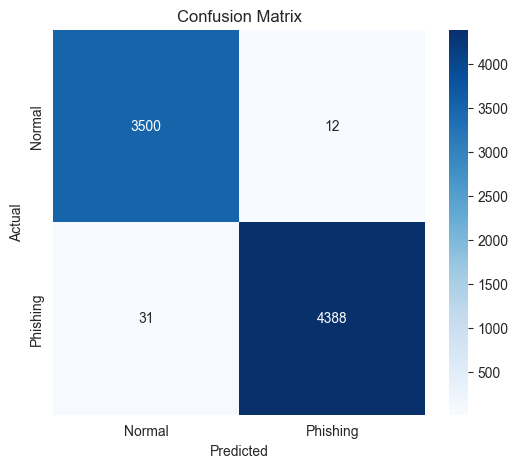

In [ ]:
# 모델 성능 시각화(혼동 행렬) => 오차 종류 파악

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Phishing'],  # x축: 예측값
            yticklabels=['Normal', 'Phishing'])  # y축: 실제값
plt.xlabel('Predicted')  # 예측값
plt.ylabel('Actual')     # 실제값
plt.title('Confusion Matrix')  # 차트 제목
plt.show()

C:\Users\YUNJI\AppData\Local\Temp\ipykernel_5096\3574581072.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='Set2')


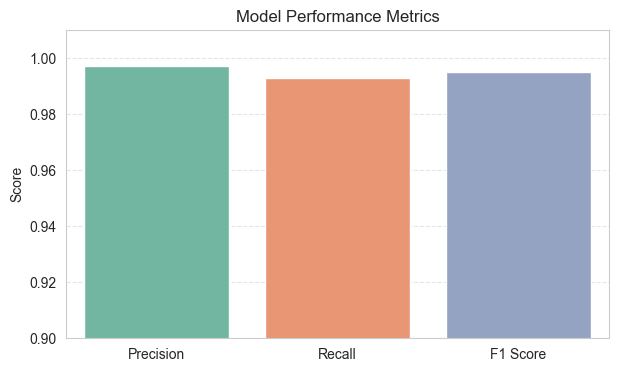

In [38]:
# 정확도 지표 막대 그래프 (Precision, Recall, F1) => 성능 지표 확인

# 성능 지표 계산
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = [precision, recall, f1]
labels = ['Precision', 'Recall', 'F1 Score'] # 정밀도, 재현율, F1점수

# 시각화
plt.figure(figsize=(7, 4))
sns.barplot(x=labels, y=metrics, palette='Set2')
plt.ylim(0.9, 1.01)  # y축 범위 설정
plt.title('Model Performance Metrics')  # 모델 성능 지표
plt.ylabel('Score')  # y축 이름 : 값
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

C:\Users\YUNJI\AppData\Local\Temp\ipykernel_5096\2109553765.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_words, palette='rocket')


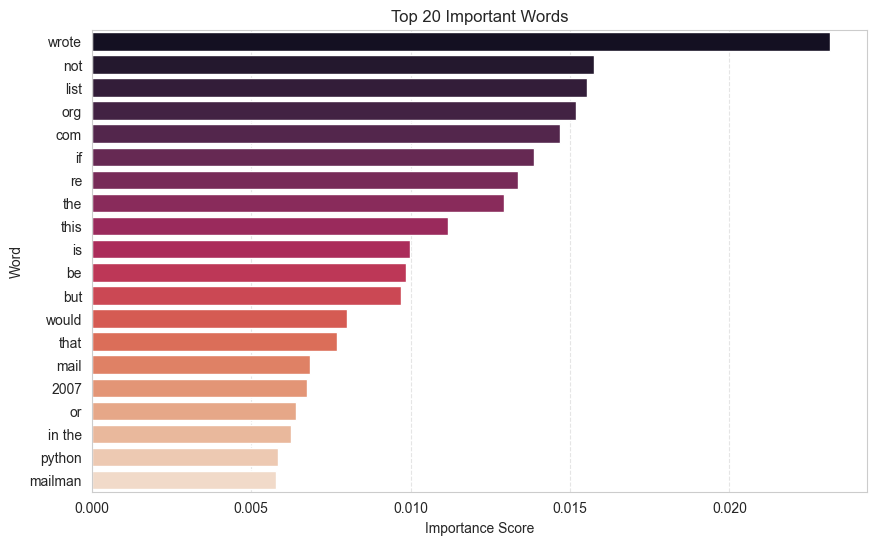

In [ ]:
# Feature Importance (중요 단어 상위 20개) => 모델 해석

# 피처 중요도 추출
importances = rf.feature_importances_
top_n = 20
top_indices = np.argsort(importances)[-top_n:][::-1]
top_words = np.array(vectorizer.get_feature_names_out())[top_indices]
top_importances = importances[top_indices]

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_words, palette='rocket')
plt.title('Top 20 Important Words')  # 중요 단어 상위 20개 (RandomForest 기준)
plt.xlabel('Importance Score')  # x축 이름 : 중요도 (Feature Importance)
plt.ylabel('Word')              # y축 이름 : 단어
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

# => 한글 파일 합쳐도 비율이 너무 적음

In [ ]:
# 오분류된 이메일 샘플 보기 => 오류 원인 분석

# 예측이 틀린 샘플만 추출
test_df = pd.DataFrame({'text': X_test, 'label': y_test, 'pred': y_pred})
misclassified = test_df[test_df['label'] != test_df['pred']]

# 상위 5개 샘플 확인
print("오분류된 이메일 샘플:")
print(misclassified[['text', 'label', 'pred']].head(5))  # 오분류된 메일의 본문 및 실제/예측 라벨

오분류된 이메일 샘플:
                                                    text  label  pred
20190  [gc] FIre aaahaaaahhh Hi all,\n\nHow the burn ...      0     1
13105  slash article I like this line "Some days Duff...      0     1
205    This works for any product, website or affilia...      1     0
28522  Secondary CD/DVD Image Downloading    This is ...      1     0
19445  RE: [lwv-healthcare] information source Mr. Az...      1     0
